In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#%% Prepare dataset

# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reshape
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Model / data parameters
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1::]

Model: "mobilenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 28, 28, 1)         10        
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 24)        48        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 24)        0         
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 14, 14, 24)        624       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1600      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0 

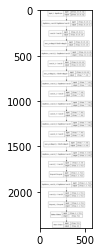

In [3]:
#%% Create model
inputs = tf.keras.Input(shape=input_shape)

# Depthwise separable convolution
def MobileNetConv2D(inputs, kernel_size, filters, padding): 
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=kernel_size, padding=padding)(inputs) # Convolution per channel
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(1, 1), activation='relu')(x) # Point-wise convolution (1x1)
    return x

x = MobileNetConv2D(inputs, (3, 3), 24, 'same')
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = MobileNetConv2D(x, (5, 5), 64, 'same')
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = MobileNetConv2D(x, (3, 3), 96, 'same')
x = MobileNetConv2D(x, (3, 3), 96, 'same')
x = MobileNetConv2D(x, (3, 3), 64, 'same')
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = MobileNetConv2D(x, (3, 3), 512, 'valid')
x = tf.keras.layers.Dropout(0.4)(x)
x = MobileNetConv2D(x, (1, 1), 512, 'same')
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="mobilenet")

dot_img_file = 'mobilenetmini.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
plt.figure()
plt.imshow(plt.imread(dot_img_file))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)


print(model.summary())

In [4]:
#%% Train model

batch_size = 256
epochs = 50

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

history = model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=[earlystop],
                    use_multiprocessing=True,
                    validation_data=(x_test, y_test))

Epoch 1/50
235/235 [==============================] - 10s 19ms/step - loss: 1.1547 - accuracy: 0.5806 - val_loss: 0.2061 - val_accuracy: 0.9348
Epoch 2/50
235/235 [==============================] - 3s 14ms/step - loss: 0.1866 - accuracy: 0.9416 - val_loss: 0.1122 - val_accuracy: 0.9619
Epoch 3/50
235/235 [==============================] - 3s 14ms/step - loss: 0.1231 - accuracy: 0.9612 - val_loss: 0.0799 - val_accuracy: 0.9727
Epoch 4/50
235/235 [==============================] - 3s 14ms/step - loss: 0.0926 - accuracy: 0.9714 - val_loss: 0.0645 - val_accuracy: 0.9804
Epoch 5/50
235/235 [==============================] - 4s 15ms/step - loss: 0.0742 - accuracy: 0.9767 - val_loss: 0.0569 - val_accuracy: 0.9809
Epoch 6/50
235/235 [==============================] - 3s 14ms/step - loss: 0.0677 - accuracy: 0.9790 - val_loss: 0.0493 - val_accuracy: 0.9840
Epoch 7/50
235/235 [==============================] - 3s 14ms/step - loss: 0.0581 - accuracy: 0.9822 - val_loss: 0.0470 - val_accuracy: 0.984

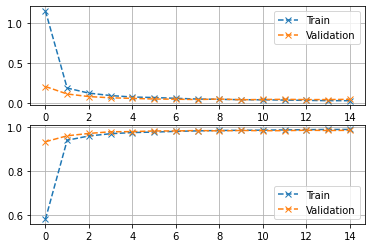

In [5]:
#%% Model visualization
plt.figure()
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(history.history['loss'], '--x')
plt.plot(history.history['val_loss'], '--x')
plt.legend(['Train', 'Validation'])
plt.subplot(2, 1, 2)
plt.grid()
plt.plot(history.history['accuracy'], '--x')
plt.plot(history.history['val_accuracy'], '--x')
plt.legend(['Train', 'Validation'])

In [6]:
#%% Model evaluation
result = model.evaluate(x_test, y_test)
print("Test accuracy: {:.2f}%".format(result[1]*100))

313/313 [==============================] - 2s 4ms/step - loss: 0.0399 - accuracy: 0.9863
Test accuracy: 98.63%
